(480, 640)


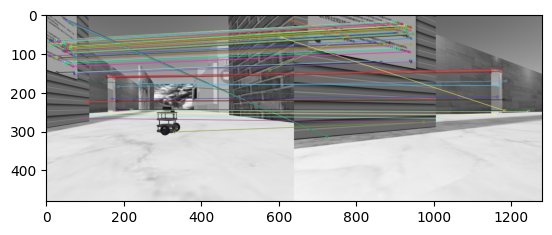

In [2]:
import numpy as np
from RelaPose_2pc_function import *
import cv2 as cv
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pytransform3d.transformations as pt
from pytransform3d.transform_manager import TransformManager
import math
img1 = cv.imread("/home/master/debug/robot1.jpg")
img2 = cv.imread("/home/master/debug/robot2.jpg")
img1 = cv.cvtColor(img1,cv.COLOR_BGR2GRAY)
img2 = cv.cvtColor(img2,cv.COLOR_BGR2GRAY)
cam_rotation = [[0,0,0],[-0.2,0.1,math.pi/2],[-0.4,0.0,math.pi],[-0.2,-0.1,-math.pi/2]]
height = img1.shape[0]
widht = img1.shape[1]//4
img1_list = []
img2_list = []
for i in range(4):
    img1_tmp = img1[0:height,i*widht:(i+1)*widht]
    img2_tmp = img2[0:height,i*widht:(i+1)*widht]

    img1_list.append(img1_tmp)
    img2_list.append(img2_tmp)


tmp = img1_list[0]
# plt.imshow(tmp,cmap=plt.get_cmap('gray'))
print(tmp.shape)
# read K
K1_mat=np.array([319.9988245765257, 0.0, 320.5, 0.0, 319.9988245765257, 240.5, 0.0, 0.0, 1.0]).reshape((3,3))
K2_mat=np.array([319.9988245765257, 0.0, 320.5, 0.0, 319.9988245765257, 240.5, 0.0, 0.0, 1.0]).reshape((3,3))

best_model = planar_motion_calcu(img1_list[1],img2_list[2],K1_mat,K2_mat)